In [2]:
# numerical libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

Let $T$ denote the discretized time grid, $N$ denote the discretized spatial domain. Backward-time-centered-space refers to expanding around $U_N^{T+1}$ using:
$$
    \partial_t u \approx \frac{U_{N}^{T+1} - U_N^{T}}{k}
$$
$$
    \partial_{xx}u \approx \frac{U_{N+1}^{T+1}-2U_{N}^{T+1}+U_{N-1}^{T+1}}{h^2}
$$

Original equation:
$$
    u_t = 0.025u_{xx} + e^{\xi(x,\omega)}u(1-u) 
$$
$$
    u(0,x) = \chi_{[0,1]}(x), u(t,0) = 1, u(t,T=15) = 0
$$ where $\xi(x,\omega)=X_t$ is an OU-process with $X_0 \sim\mathcal{N}(0,1)$.

Rearranging, we obtain the implicit scheme (let $i,j$ denote space and time indices); notice that we actually should use backward for the nonlinear term $u(1-u)$ and solve a nonlinear equation with, for instance, Newton's method. But most students implemented a forward scheme, and it is okay too.

$$
    \frac{1}{k}(u_{i,j+1} - u_{i,j}) =\frac{1}{40h^2}(u_{i+1,j} - 2u_{i,j} + u_{i-1,j}) + \exp[\xi(x_i,\omega)]u_{i,j}(1-u_{i,j})
$$

$$
    u_{i,j+1}  = u_{i,j} + \frac{k}{40h^2}(u_{i+1,j}-2u_{i,j}+u_{i-1,j}) + k\exp[\xi(x_i,\omega)]u_{i,j}(1-u_{i,j})
$$

In [3]:
# fix seed
np.random.seed(1)
h = 0.01
k = 0.0001

x = np.arange(0,15,h)
t_end = 20 # 0, 4, 8, 12, 16, 20.
t = np.arange(0,t_end,k)

# number of spatial points
num_space = len(x)
# number of time points
num_time = len(t)

# pre-allocate 
u = np.zeros([num_time, num_space])
# initial conditions
u[:, 0] = 1
u[:, -1] = 0
indicator_idx = np.where(x == 1)[0][0]
u[0, 0:indicator_idx+1] = 1
# generate Brownian motion
dWt = np.sqrt(h)*np.random.randn(num_space)
# Simulate OU-Process (See Project 2 Solutions)
x0 = np.random.randn()
xi_t = np.exp(-2*x)*(x0 + 2*np.cumsum(np.exp(2*x) * dWt))
# forward time stepping
for i in np.arange(1, num_time):
    u[i, 1:num_space-1] = u[i-1, 1:num_space-1] + (k/(40*(h**2))) * (u[i-1, 2:num_space] - \
                                                                2*u[i-1, 1:num_space-1] + \
                                                                u[i-1, 0:num_space-2]) + \
                                                                k * np.exp(xi_t[1:num_space-1]) * \
                                                                    u[i-1, 1:num_space-1] * \
                                                                    (1 - u[i-1, 1:num_space-1])
# end for loop

#### (a) Plot sample solution

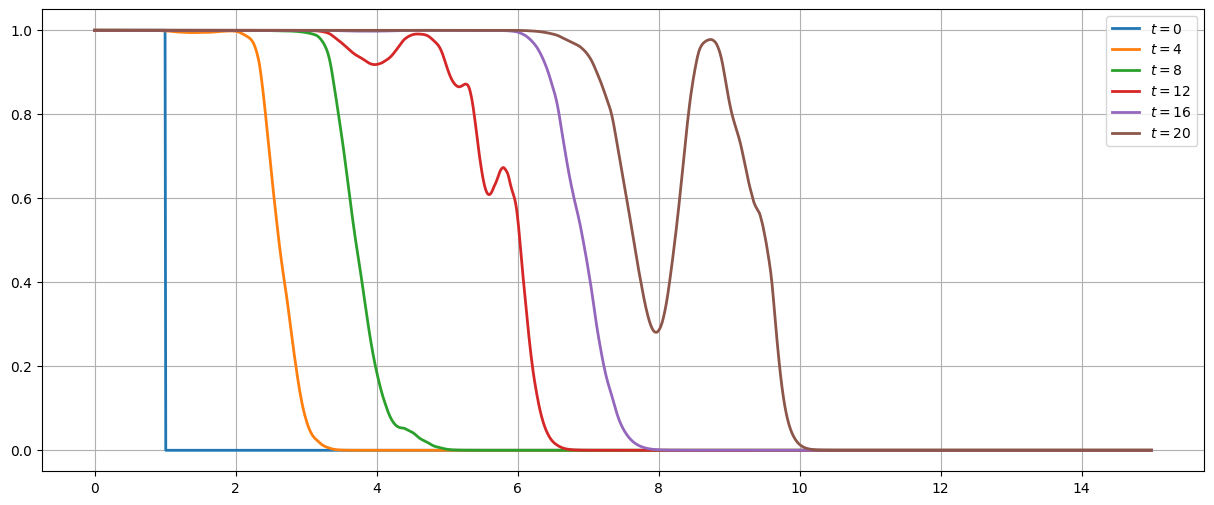

In [4]:
# find indices of t
idx4 = np.where(t == 4)[0][0]
idx8 = np.where(t == 8)[0][0]
idx12 = np.where(t == 12)[0][0]
idx16 = np.where(t == 16)[0][0]
plt.figure(1, figsize=(15, 6));
plt.plot(x, u[0, :], lw=2, label=r"$t=0$");
plt.plot(x, u[idx4, :], lw=2, label=r"$t=4$");
plt.plot(x, u[idx8, :], lw=2, label=r"$t=8$");
plt.plot(x, u[idx12, :], lw=2, label=r"$t=12$");
plt.plot(x, u[idx16, :], lw=2, label=r"$t=16$");
plt.plot(x, u[-1, :], lw=2, label=r"$t=20$");
plt.grid(True);
plt.legend();

#### (b) Histogram

Due to randomness, $u$ will not be exactly 2, we thus find all solutions such that:
$$
    |u(\cdot, \cdot; \omega) - \frac12| < \epsilon
$$ where we choose $\epsilon$ small. We take $N = 2000$ as our sample size.

In [10]:
mc = 2000

h = 0.01
k = 0.001

x = np.arange(0,15,h)
t_end = 20 # 0, 4, 8, 12, 16, 20.
t = np.arange(0,t_end,k)

# number of spatial points
num_space = len(x)
# number of time points
num_time = len(t)

# ensemble solution
save_x = np.zeros([mc, num_space])

# preallocate
eta1 = []
u_mean = np.zeros((num_time,num_space))
for idx in range(mc):
    if idx % 100 == 0:
        print("[#] sample {}".format(idx))
    # pre-allocate 
    u = np.zeros([num_time, num_space])
    # initial conditions
    u[:, 0] = 1
    u[:, -1] = 0
    indicator_idx = np.where(x == 1)[0][0]
    u[0, 0:indicator_idx+1] = 1
    # generate Brownian motion
    dWt = np.sqrt(h)*np.random.randn(num_space)
    # Simulate OU-Process (See Project 2 Solutions)
    x0 = np.random.randn()
    xi_t = np.exp(-2*x)*(x0 + 2*np.cumsum(np.exp(2*x) * dWt))
    
    # forward time stepping
    for i in np.arange(1, num_time):
        u[i, 1:num_space-1] = u[i-1, 1:num_space-1] + (k/(40*(h**2))) * (u[i-1, 2:num_space] - \
                                                                    2*u[i-1, 1:num_space-1] + \
                                                                    u[i-1, 0:num_space-2]) + \
                                                                    k * np.exp(xi_t[1:num_space-1]) * \
                                                                        u[i-1, 1:num_space-1] * \
                                                                        (1 - u[i-1, 1:num_space-1])
    u_mean += u / mc
    
    # after solving u, take 1/2-process
    minimum_idx = np.argmin(np.abs(u[-1, :]-0.5))
    eta1.append(x[minimum_idx])

[#] sample 0
[#] sample 100
[#] sample 200
[#] sample 300
[#] sample 400
[#] sample 500
[#] sample 600
[#] sample 700
[#] sample 800
[#] sample 900
[#] sample 1000
[#] sample 1100
[#] sample 1200
[#] sample 1300
[#] sample 1400
[#] sample 1500
[#] sample 1600
[#] sample 1700
[#] sample 1800
[#] sample 1900


As a sanity check, the ensemble solution should correspond to roughly a pure advection-diffusion. 

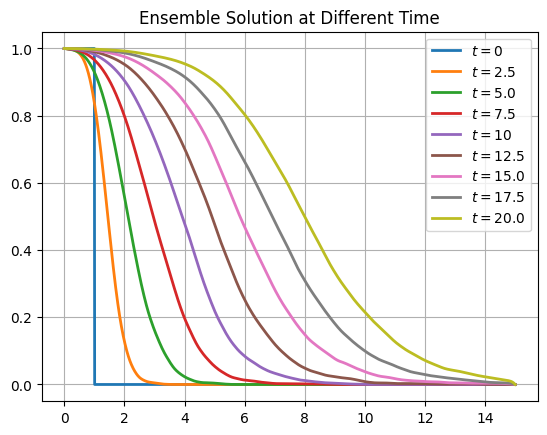

In [24]:
plt.plot(x, u_mean[0, :], lw=2, label=r"$t=0$");
plt.plot(x, u_mean[2500, :], lw=2, label=r"$t=2.5$");
plt.plot(x, u_mean[5000, :], lw=2, label=r"$t=5.0$");
plt.plot(x, u_mean[7500, :], lw=2, label=r"$t=7.5$");
plt.plot(x, u_mean[10000, :], lw=2, label=r"$t=10$");
plt.plot(x, u_mean[12500, :], lw=2, label=r"$t=12.5$");
plt.plot(x, u_mean[15000, :], lw=2, label=r"$t=15.0$");
plt.plot(x, u_mean[17500, :], lw=2, label=r"$t=17.5$");
plt.plot(x, u_mean[-1, :], lw=2, label=r"$t=20.0$");
plt.title("Ensemble Solution at Different Time")
plt.grid(True);
plt.legend();

#### (c) Estimate speed

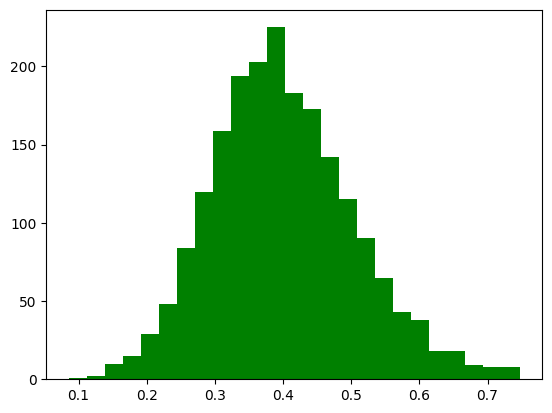

In [21]:
# histogram
plt.figure(2);
eta1 = np.array(eta1)/20
plt.hist(eta1, color='green', bins=25);

In [ ]:
c = np.mean(eta1)
# simulate exp(xi) N times
mc = 10000
ensemble_exp_xi = 0
for idx in range(mc):
    dWt = np.sqrt(h)*np.random.randn(num_space)
    x0 = np.random.randn()
    xi_t = np.exp(-2*x)*(x0 + 2*np.cumsum(np.exp(2*x) * dWt))
    ensemble_exp_xi += np.exp(xi_t)[-1]
ensemble_exp_xi /= mc
c_prime = 2 * np.sqrt(0.025 * ensemble_exp_xi)
print("[*] Compare c = {}, c' = {}".format(c, c_prime))